# Assignment-1

## Sentiment analyisis of generic and US airline tweets

### Research question: “What can public opinion on Twitter tell us about the US airlines in 2015?”

Following is the script for the analysis.

### Installation of necessary libraries
Following are the libraries that are used throughout the program.

In [1]:
!pip install nltk
!pip install bs4
!pip install textblob
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install regex
!pip install sklearn

### Importing all the libraries and associated sub-packages

In [2]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn
from textblob import TextBlob
import nltk
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /home/jupyterlab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Reading the different files
> 1. "generic_tweets.txt" into pandas dataframe df_gt
> 2. "US_airline_tweets.csv" in to pandas dataframe df_at
> 3. "stop_words.txt" read as a text file and stop words extracted as a list: sw_list

In [3]:
df_gt = pd.read_csv("generic_tweets.txt")
df_at = pd.read_csv("US_airline_tweets.csv")
sw = open("stop_words.txt",'r')
sw_list = str(sw.read()).split('\n')

Checking the number of samples for each data set

In [4]:
len(df_gt), len(df_at)

(200000, 11541)

Removing any duplicate entries in the data set and resetting the index for both datasets.

In [5]:
df_gt = df_gt.drop_duplicates()
df_gt = df_gt.reset_index(drop=True)

In [6]:
df_at = df_at.drop_duplicates()
df_at = df_at.reset_index(drop=True)

Checking the number of samples after removing duplicates. The number of generic tweets remain the same but there were some duplicates in the US airline tweets which have now been removed.

In [7]:
len(df_gt), len(df_at)

(200000, 11458)

Creating a column containing the length of each tweet in both datasets before any pre-processing/cleaning step.

In [8]:
df_gt['Length'] = [len(tweet) for tweet in df_gt['text']]

In [9]:
df_at['Length'] = [len(tweet) for tweet in df_at['text']]

### Data cleaning

Removing all html tags, attributes and character codes in the 'text' column of both dataframes using BeautifulSoup library. The operation was performed twice in order to ensure removal of all html associated characters.

In [10]:
df_gt['text'] = df_gt['text'].apply(lambda x: BeautifulSoup(BeautifulSoup(x).get_text()).get_text())

In [11]:
df_at['text'] = df_at['text'].apply(lambda x: BeautifulSoup(BeautifulSoup(x).get_text()).get_text())

Recording the modified length of the tweet in a separate column "Length_2".

In [12]:
df_gt['Length_2'] = [len(tweet) for tweet in df_gt['text']]

In [13]:
df_at['Length_2'] = [len(tweet) for tweet in df_at['text']]

Removing all other remaining special characters in the text by encoding in ascii and decoding to string.

In [14]:
df_gt['text'] = df_gt['text'].apply(lambda x: x.encode(encoding = 'ascii',errors='replace').decode())

In [15]:
df_at['text'] = df_at['text'].apply(lambda x: x.encode(encoding = 'ascii',errors='replace').decode())

Removing all punctuation in the text by replacing it with empty string.

In [16]:
for punctuation in [',','.','!','*','?','[',']','/','+','(',')','%','$','~','<','>','"',';',':','#']:
    df_gt['text'] = df_gt['text'].apply(lambda x: x.replace(punctuation,''))

In [17]:
for punctuation in [',','.','!','*','?','[',']','/','+','(',')','%','$','~','<','>','"',';',':','#']:
    df_at['text'] = df_at['text'].apply(lambda x: x.replace(punctuation,''))

Filtering away the URLs (all words starting with 'http') from both dataframes

In [18]:
df_gt['text'] = df_gt['text'].apply(lambda y: " ".join(filter(lambda x:x[0:4]!='http', y.split())))

In [19]:
df_at['text'] = df_at['text'].apply(lambda y: " ".join(filter(lambda x:x[0:4]!='http', y.split())))

Filtering away all the '@' tagged words from the generic tweets dataframe (since it is not needed for this case).

In [20]:
df_gt['text'] = df_gt['text'].apply(lambda y: " ".join(filter(lambda x:x[0]!='@', y.split())))

Collecting all the '@' tagged words in each tweet of the US airline dataset, in a separate column (for future extraction of airline name).

In [21]:
airline_tags=[]
for tweet in df_at["text"]:
    airlines = re.findall(r'@\w+',tweet)
    airlines = " ".join(airlines)
    airline_tags.append(airlines)
df_at['@ tag words']=airline_tags

Filtering away all the '@' tagged words from the US airline tweets dataframe (since we already have them separately).

In [22]:
df_at['text'] = df_at['text'].apply(lambda y: " ".join(filter(lambda x:x[0]!='@', y.split())))

Recording the modified length of the tweet as a new column

In [23]:
df_gt['Length_3'] = [len(tweet) for tweet in df_gt['text']]

In [24]:
df_at['Length_3'] = [len(tweet) for tweet in df_at['text']]

### Minor digression into 'Exploratory Analysis'
#### Determination of airline

Creating a potential set of airline tweets, taken from the first '@' tag in each tweet.

In [25]:
tag_set = set([])
max_words = 0
for collection in list(df_at['@ tag words']):
    words = collection.split()
    max_words = max(max_words,len(words))
    if len(words) == 1:
        tag_set.add(words[0].lower())

new_set = set()
for collection in list(df_at['@ tag words']):
    words = collection.split()
    words = [x.lower() for x in words]
    words_set = set(words)
    if words_set.intersection(tag_set) == set():
        new_set = new_set.union(words_set)

Creating a dictionary containing all major airline names and their associated tags extracted from the previous step as well as additional tags searched online.

##### NOTE:
Since Virgin America has been acquired by Alaska Airlines, all @virginamerica tweets are considered under Alaska Airlines.

In [26]:
tags_dict = {'American Airlines':{'@americanair', '@americanairif', '@americanairstill', '@aairwaves'},
'Delta Air Lines':{'@deltaassist','@delta'},
'JetBlue':{'@jetblue'},
'Southwest Airlines':{'@southwestair', '@southwestairgive'},
'United Airlines':{'@united', '@unitedlies', '@unitedâ','@ualistheworst'},
'US Airways':{'@usairways'},
'Alaska Airlines':{'@virginamerica','@alaskaair','@alaskafleet'},
'Allegiant Air': {'@allegiant'},
'Frontier Airlines':{'@flyfrontier', '@frontiercare', '@frontier_ripoff'},
'Hawaiian Airlines':{'@hawaiianair','flyhawaiian','@dontflyhawaiian'},
'Spirit Airlines':{'@spiritairlines', '@spiritairsucks'}}

Creating a separate column containing the list of all airlines associated with a particular tweet (all text converted to lower case before use)

##### NOTE:
There is more than one airline associated with a particular tweet.

In [27]:
airline_tags = []
for collection in list(df_at['@ tag words']):
    words = collection.split()
    words = [x.lower() for x in words]
    words = set(words)
    airline_tags_list = []
    for airline in tags_dict.keys():
        if tags_dict[airline].intersection(words) != set():
            airline_tags_list.append(airline)
    airline_tags.append(airline_tags_list)
df_at['Airline'] = airline_tags

To simplify further processing, a new column for each ariline company was created in the US airline dataframe, containing True/False values according to the presence of associated tags in the respective tweet.

In [28]:
american_air = []
delta = []
jetblue = []
swair = []
united = []
usair = []
alaskaair = []
allair = []
frontair = []
hawair = []
spair = []

for airlist in df_at['Airline']:
    if 'American Airlines' in airlist:
        american_air.append(True)
    else:
        american_air.append(False)
for airlist in df_at['Airline']:
    if 'Delta Air Lines' in airlist:
        delta.append(True)
    else:
        delta.append(False)
for airlist in df_at['Airline']:
    if 'JetBlue' in airlist:
        jetblue.append(True)
    else:
        jetblue.append(False)
for airlist in df_at['Airline']:
    if 'Southwest Airlines' in airlist:
        swair.append(True)
    else:
        swair.append(False)
for airlist in df_at['Airline']:
    if 'United Airlines' in airlist:
        united.append(True)
    else:
        united.append(False)
for airlist in df_at['Airline']:
    if 'US Airways' in airlist:
        usair.append(True)
    else:
        usair.append(False)
for airlist in df_at['Airline']:
    if 'Alaska Airlines' in airlist:
        alaskaair.append(True)
    else:
        alaskaair.append(False)
for airlist in df_at['Airline']:
    if 'Allegiant Air' in airlist:
        allair.append(True)
    else:
        allair.append(False)
for airlist in df_at['Airline']:
    if 'Frontier Airlines' in airlist:
        frontair.append(True)
    else:
        frontair.append(False)
for airlist in df_at['Airline']:
    if 'Hawaiian Airlines' in airlist:
        hawair.append(True)
    else:
        hawair.append(False)
for airlist in df_at['Airline']:
    if 'Spirit Airlines' in airlist:
        spair.append(True)
    else:
        spair.append(False)

df_at['American Airlines'] = american_air
df_at['Delta Air Lines'] = delta
df_at['JetBlue'] = jetblue
df_at['Southwest Airlines'] = swair
df_at['United Airlines'] = united
df_at['US Airways'] = usair
df_at['Alaska Airlines'] = alaskaair
df_at['Allegiant Air'] = allair
df_at['Frontier Airlines'] = frontair
df_at['Hawaiian Airlines'] = hawair
df_at['Spirit Airlines'] = spair

### Data cleaning - continued

#### Conversion to lower case and removal of stop words

Converting all text to lower case and removal of stop words before and after removal of apostrophe (') to facilitate removal of stop words like "I'll" and also words like "wont". Stop words are taken from the stop_words optional file, loaded in the beginning.

In [29]:
df_gt['text'] = df_gt['text'].apply(lambda x: x.lower())
df_gt['text'] = df_gt['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw_list))
df_gt['text'] = df_gt['text'].apply(lambda x: x.replace("'",''))
df_gt['text'] = df_gt['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw_list))

In [30]:
df_at['text'] = df_at['text'].apply(lambda x: x.lower())
df_at['text'] = df_at['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw_list))
df_at['text'] = df_at['text'].apply(lambda x: x.replace("'",''))
df_at['text'] = df_at['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw_list))

Recording the final length of the tweet as a new column.

In [31]:
df_gt['Length_4'] = [len(tweet) for tweet in df_gt['text']]

In [32]:
df_at['Length_4'] = [len(tweet) for tweet in df_at['text']]

### Exploratory analysis

Plotting the distribution of all tweets among different airlines.

Text(0.5, 1.0, 'Distribution of tweets among different airlines')

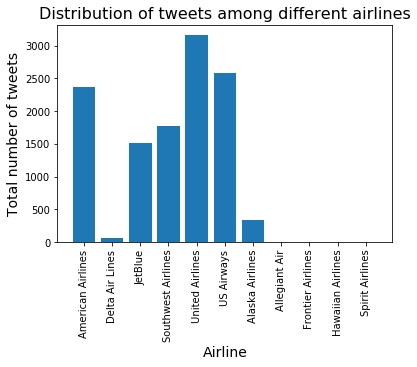

In [33]:
X = np.arange(len(tags_dict.keys()))
Y = [len(df_at[df_at[airline]]) for airline in tags_dict.keys()]
width = 0.8
p1 = plt.bar(X, Y, width)
plt.xticks(X,tags_dict.keys(),rotation='vertical')
plt.xlabel('Airline', fontsize=14)
plt.ylabel('Total number of tweets', fontsize = 14)
plt.title('Distribution of tweets among different airlines', fontsize = 16)

In [34]:
print(Y)

[2368, 59, 1509, 1780, 3164, 2590, 344, 0, 1, 0, 8]


It can be seen from the above plot that United Airlines has the maximum number of tweets followed by US Airways (now discontinued), American Airlines, Southwest Airlines JetBlue, Alaska Airlines (including Virgin America), Delta Airlines, Spirit Airlines and Frontier Airlines.

Furthermore, it would be better to see the distribution of positive and negative tweets among these. Therefore the following figure was plotted.

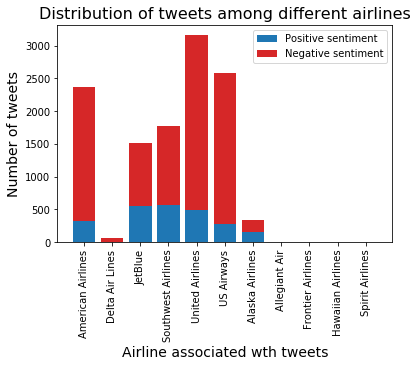

In [35]:
X = np.arange(len(tags_dict.keys()))
df_at_positive = df_at[df_at['sentiment'] == 'positive']
df_at_negative = df_at[df_at['sentiment'] == 'negative']
Y1 = [len(df_at_positive[df_at_positive[airline]]) for airline in tags_dict.keys()]
Y2 = [len(df_at_negative[df_at_negative[airline]]) for airline in tags_dict.keys()]
p1 = plt.bar(X, Y1)
p2 = plt.bar(X, Y2, bottom = Y1, color='#d62728')
plt.xticks(X,tags_dict.keys(), rotation='vertical')
plt.ylabel("Number of tweets", fontsize = 14)
plt.xlabel("Airline associated wth tweets", fontsize = 14)
plt.title("Distribution of tweets among different airlines", fontsize = 16)
plt.legend((p1[0], p2[0]), ('Positive sentiment', 'Negative sentiment'), loc='best')

The plot shows that majority of tweets among most of the different airlines have negative sentiment.

A better representation to study that distribution would be the percentage of positive tweets plotted for each airline.

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Plot showing percentage of positive tweets among different airlines')

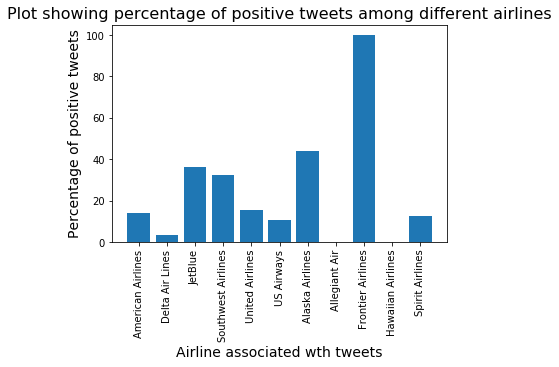

In [36]:
Y3 = np.divide(Y1,np.add(Y1,Y2))*100
plt.bar(X,Y3)
plt.xticks(X,tags_dict.keys(), rotation='vertical')
plt.ylabel("Percentage of positive tweets",fontsize = 14)
plt.xlabel("Airline associated wth tweets",fontsize = 14)
plt.title("Plot showing percentage of positive tweets among different airlines",fontsize = 16)

Here we see that Frontier Airlines has the maximum percentage of positive tweets (actually 100% because there is only one positive tweet in total for it). Alaska Airlines (Virgin America) comes next followed by JetBlue Southwest Airlines and others as shown in the Figure above.

### Some inferences
1. Since for most airlines, the sentiment of the tweets is negative, it indicates that twitter is one way through which customers vent-out their dissatisfaction with the airline service. Therefore, judging an airline service solely by the tweet sentiment may result in erroneous preconceptions.
2. Since United Airlines, US Airways and American Airlines are the ones with highest number of tweets, these are probably the most frequently used by customers (probably because of their fleet size, connectivity, flight schedules, etc.) in the United States in 2015, assuming the same ratio of customers tweeting among all those who travel, for all airlines.
3. JetBlue, Southwest Airlines and Alaska Airlines seem to have more balanced sentiment compared to top three, suggesting better customer experience than others.
4. Delta Airlines, Allegiant Air, Frontier Airlines, Hawaiian Airlines and Spirit Airlines seem to be less crowded (maybe because of lesser fleet size or inappropriate schedules, etc.) resulting in low number of tweets in total. Another reason might be that the type of customers using these airlines may not be using twitter that often.

Text(0.5, 1.0, 'Plot showing number of positive and negative sentiment tweets')

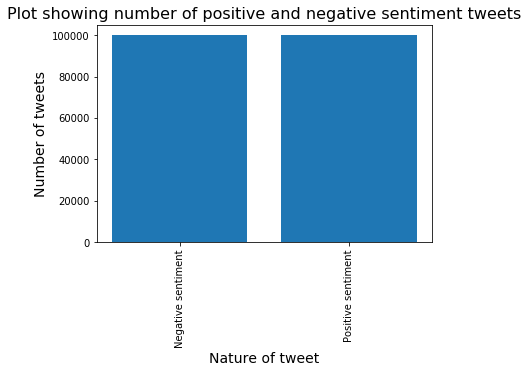

In [37]:
plt.bar(['Negative sentiment','Positive sentiment'],[len(df_gt[df_gt['class'] == 0]),len(df_gt[df_gt['class'] == 4])])
plt.xticks(rotation='vertical')
plt.ylabel("Number of tweets",fontsize = 14)
plt.xlabel("Nature of tweet",fontsize = 14)
plt.title("Plot showing number of positive and negative sentiment tweets",fontsize = 16)

The above plot shows that the generic tweets are equally distributed among positive and negative sentiment tweets.

In [38]:
positive_gt = df_gt[df_gt['class'] == 0]
negative_gt = df_gt[df_gt['class'] == 4]

### BONUS Figure

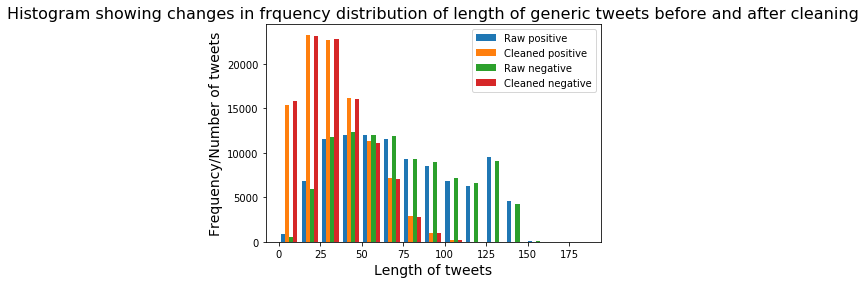

In [39]:
plt.hist([list(positive_gt['Length']), list(positive_gt['Length_4']),negative_gt['Length'], list(negative_gt['Length_4'])],bins=15)
plt.xlabel("Length of tweets",fontsize = 14)
plt.ylabel("Frequency/Number of tweets",fontsize = 14)
plt.title("Histogram showing changes in frquency distribution of length of generic tweets before and after cleaning",fontsize = 16)
plt.legend(('Raw positive', 'Cleaned positive','Raw negative','Cleaned negative'),loc='best')

An interesting thing to look at here is the frequency distribution of the length of tweets before and after data cleaning.
1. The frequency distribution apprears more like a normal distribution after the data cleaning, with the bin [15,30) having the maximum frequency for clean tweets (meaning maximum number of clean tweets are between 15 to 30 characters in length) and bins [45,90) and [90,105) having maximum frequencies for raw unprocessed tweets.
2. The distribution of positive and negative tweets in each bin for both raw and cleaned tweets is quite similar suggesting the following:
>1. The cleaning procedure applied is not biased towards positive or negative sentiment tweets.
>2. Both positive and negative sentiment tweets are equally distributed based on their length (almost equal number of positive and negative sentiment tweets exist for all tweet lengths).

### Model preparation

The data can now be prepared for feeding into to the Logistic regrassion model.

Following piece of code, tokenizes (breaks the tweet into a list of words) the tweet in both datasets and records the Word list and Word count in new separate columns.

In [40]:
df_gt['Word_list'] = [TextBlob(x).words for x in df_gt['text']]
df_gt['Word_count'] = [len(x) for x in df_gt['Word_list']]

In [41]:
df_at['Word_list'] = [TextBlob(x).words for x in df_at['text']]
df_at['Word_count'] = [len(x) for x in df_at['Word_list']]

In [42]:
len(df_gt), len(df_at)

(200000, 11458)

For building the features of the logistic model, the bag of words approach was used, wherein the frequency of unigrams (individual words) and bigrams was recorded for each tweet and used as feautres. This was implemented using the CountVectorizer in scikit-learn library. The maximum number of features was kept at 1000 as the program runs into a "Memory error" beyond that number of features.

A new matrix X_gt for generic tweets (and X_at for airline tweets, created later) was created containing the unigram and bigram frequency of occurence in each cell, corresponding to the tweet in that particular row.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_gt = CountVectorizer(max_features=1000,ngram_range=(1, 2))
X_gt = vectorizer_gt.fit_transform(df_gt['text'])

In [44]:
len(vectorizer_gt.get_feature_names())

1000

In [45]:
X1_gt = X_gt.toarray()

In [46]:
columns_gt = vectorizer_gt.get_feature_names()

In [47]:
type(columns_gt)

list

The array was converted into a pandas dataframe with column heads as the unigrams and bigrams that form the features of the model.

In [48]:
df_gt_bow = pd.DataFrame(data=X1_gt, columns=columns_gt)

The output of the model was recorded as a pandas Series Y_gt, containing the class labels for each tweet.

In [49]:
Y_gt = df_gt['class']

A list of indices for the generic tweets dataset was obtained.

In [50]:
df_gt_index = list(df_gt_bow.index)

The list of indices was split into training (70%) and testing (30%) data set indices.

In [51]:
from sklearn.model_selection import train_test_split
train_indices_gt, test_indices_gt = train_test_split(df_gt_index,test_size=0.3)

In [52]:
len(train_indices_gt), len(test_indices_gt)

(140000, 60000)

The train and test indices were then used to obtain the entire training and tesing data set using the iloc method.

In [53]:
X_gt_train = df_gt_bow.iloc[train_indices_gt]
Y_gt_train = Y_gt[train_indices_gt]

X_gt_test = df_gt_bow.iloc[test_indices_gt]
Y_gt_test = Y_gt[test_indices_gt]

The training dataset was fed into the default logistic regression model in scikit-learn to build the logistic model for the generic tweets.

In [54]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_gt_train,Y_gt_train)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Predictions from the model were obtained for the test dataset.

In [55]:
predictions = model.predict(X_gt_test)

The accuracy score [(true positive + true negative)/total] was computed based on the expected predictions from the test dataset and the percentage score was printed.

In [56]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_gt_test,predictions)
print (score*100)

70.87833333333333


A classification report was also generated using the predictions and expected Y values. This shows the precision value of each class (true/total), the recall score [true positives/(true positives + false negatives)] and the F1 score (best: 1, worst: 0)

In [57]:
from sklearn.metrics import classification_report
print(classification_report(Y_gt_test,predictions))

              precision    recall  f1-score   support

           0       0.75      0.63      0.69     30030
           4       0.68      0.78      0.73     29970

   micro avg       0.71      0.71      0.71     60000
   macro avg       0.71      0.71      0.71     60000
weighted avg       0.71      0.71      0.71     60000



A confusion matrix was also printed, which contains predicted classes as column headings and actual classes in rows.

In [58]:
from sklearn.metrics import confusion_matrix
print (confusion_matrix(Y_gt_test,predictions))

[[19027 11003]
 [ 6470 23500]]


In [59]:
predictions

array([0, 4, 4, ..., 4, 0, 4])

Similar procedure applied for obtaining features from airline tweets dataset.
1. Unigrams and bigrams used
2. Maximum number of features = 1000
3. Output obtained as a matrix
4. Converted into a dataframe
5. The same dataframe used as the test dataset for the model generated using generic tweets.
6. Output predictions obtained
7. Classification metrics obtained.

In [60]:
vectorizer_at = CountVectorizer(max_features=1000,ngram_range=(1, 2))
X_at = vectorizer_at.fit_transform(df_at['text'])

In [61]:
X1_at = X_at.toarray()

In [62]:
columns_at = vectorizer_at.get_feature_names()

In [63]:
df_at_bow = pd.DataFrame(data=X1_at, columns=columns_at)

In [64]:
Y_at_test = df_at['sentiment']

In [65]:
Y_at_test = Y_at_test.apply(lambda x: 0 if (x=='negative') else 4)

In [66]:
X_at_test = df_at_bow

In [67]:
predictions_at = model.predict(X_at_test)

In [68]:
score = accuracy_score(Y_at_test,predictions_at)
print (score*100)

54.721591900855294


In [69]:
print(classification_report(Y_at_test,predictions_at))

              precision    recall  f1-score   support

           0       0.85      0.52      0.65      9118
           4       0.26      0.64      0.37      2340

   micro avg       0.55      0.55      0.55     11458
   macro avg       0.55      0.58      0.51     11458
weighted avg       0.73      0.55      0.59     11458



In [70]:
print (confusion_matrix(Y_at_test,predictions_at))

[[4769 4349]
 [ 839 1501]]


In [71]:
df_at['Model_1_predicted_output'] = predictions_at

### BONUS Figure:
##### Plot showing predicted sentiment distribution compared to actual

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


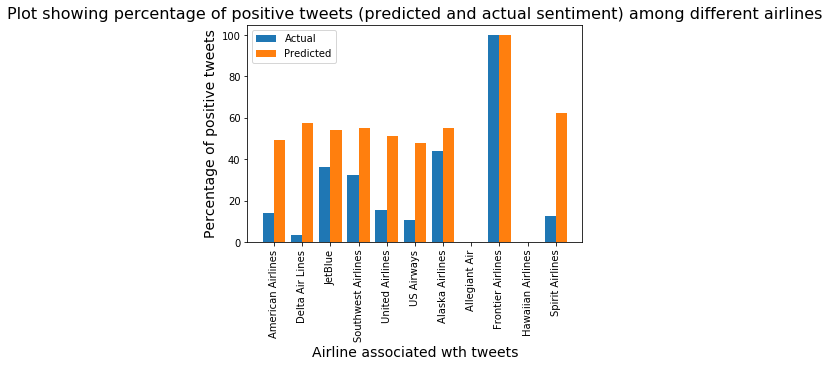

In [72]:
X = np.arange(len(tags_dict.keys()))
df_at_positive = df_at[df_at['sentiment'] == 'positive']
df_at_negative = df_at[df_at['sentiment'] == 'negative']
Y1 = [len(df_at_positive[df_at_positive[airline]]) for airline in tags_dict.keys()]
Y2 = [len(df_at_negative[df_at_negative[airline]]) for airline in tags_dict.keys()]
Y3 = np.divide(Y1,np.add(Y1,Y2))*100

df_at_positive_pred = df_at[df_at['Model_1_predicted_output'] == 4]
df_at_negative_pred = df_at[df_at['Model_1_predicted_output'] == 0]
Y4 = [len(df_at_positive_pred[df_at_positive_pred[airline]]) for airline in tags_dict.keys()]
Y5 = [len(df_at_negative_pred[df_at_negative_pred[airline]]) for airline in tags_dict.keys()]
Y6 = np.divide(Y4,np.add(Y4,Y5))*100

p1 = plt.bar(X, Y3, width = 0.4)
p2 = plt.bar(X+0.4, Y6, width = 0.4)
plt.xticks(X+0.2,tags_dict.keys(), rotation='vertical')
plt.ylabel("Percentage of positive tweets", fontsize = 14)
plt.xlabel("Airline associated wth tweets", fontsize = 14)
plt.title("Plot showing percentage of positive tweets (predicted and actual sentiment) among different airlines", fontsize = 16)
plt.legend((p1[0], p2[0]), ('Actual', 'Predicted'), loc='best')

Creating a new dataframe from the airline tweets containing only the negative sentiment tweets and resetting the index.

In [73]:
df_at_neg = df_at[df_at['sentiment'] == 'negative']
df_at_neg = df_at_neg.reset_index(drop=True)

Obtaining the top 1000 features of the new tweet set using CountVectorizer.
1. Output features as an array.
2. Converting to dataframe.
3. Generating corresponding Y values (reason for negative sentiment).
4. Splitting the indices into training and testing sets.
5. Obtaining the test and training datasets using .loc method in pandas.

In [74]:
vectorizer_at_new = CountVectorizer(max_features=1000,ngram_range=(1, 2))
X_at_new = vectorizer_at_new.fit_transform(df_at_neg['text'])

In [75]:
X1_at_new = X_at_new.toarray()

In [76]:
columns_at_new = vectorizer_at_new.get_feature_names()

In [77]:
new_X_at = pd.DataFrame(data=X1_at_new, columns=columns_at_new)

In [78]:
len(df_at_neg)

9118

In [79]:
new_Y_at = df_at_neg['negative_reason']

In [80]:
#new_Y_at = new_Y_at.apply(lambda x: reasons_dict[x])

In [81]:
train_indices_at_neg, test_indices_at_neg = train_test_split(list(df_at_neg.index),test_size=0.3)

In [82]:
len(train_indices_at_neg), len(test_indices_at_neg), len(train_indices_at_neg) + len(test_indices_at_neg) == len(df_at_neg)

(6382, 2736, True)

In [83]:
set(new_X_at.index) - set(train_indices_at_neg) == set(test_indices_at_neg)

True

In [84]:
new_X_at_train = new_X_at.loc[train_indices_at_neg]
new_X_at_test = new_X_at.loc[test_indices_at_neg]

new_Y_at_train = new_Y_at.loc[train_indices_at_neg]
new_Y_at_test = new_Y_at.loc[test_indices_at_neg]

Fitting a new logistic model to the new training and testing dataset.

Obtaining the predictions on the test set.

Outputting the classification metrics.

In [85]:
model_at = LogisticRegression()
model_at.fit(new_X_at_train,new_Y_at_train)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [86]:
predictions_at_new = model_at.predict(new_X_at_test)

In [87]:
score = accuracy_score(new_Y_at_test,predictions_at_new)
print (score*100)

61.074561403508774


In [88]:
print(classification_report(new_Y_at_test,predictions_at_new))

                             precision    recall  f1-score   support

                 Bad Flight       0.49      0.32      0.39       163
                 Can't Tell       0.43      0.52      0.47       379
           Cancelled Flight       0.76      0.69      0.73       258
     Customer Service Issue       0.64      0.75      0.69       865
            Damaged Luggage       1.00      0.10      0.18        20
Flight Attendant Complaints       0.54      0.32      0.40       160
    Flight Booking Problems       0.42      0.25      0.31       156
                Late Flight       0.70      0.71      0.70       482
               Lost Luggage       0.71      0.74      0.72       212
                  longlines       0.17      0.07      0.10        41

                  micro avg       0.61      0.61      0.61      2736
                  macro avg       0.58      0.45      0.47      2736
               weighted avg       0.61      0.61      0.60      2736



In [89]:
print (confusion_matrix(new_Y_at_test,predictions_at_new))

[[ 52  39   1  30   0   6   3  26   4   2]
 [ 15 198   7 117   0   5  11  18   8   0]
 [  1  16 179  27   0   1   8  20   4   2]
 [  8  92  27 648   0  18  25  28  16   3]
 [  0   3   0   2   2   1   0   0  12   0]
 [ 11  14   1  46   0  51   3  25   6   3]
 [  7  30   7  61   0   1  39   9   2   0]
 [  9  49  11  48   0   7   2 343  10   3]
 [  2  13   1  21   0   3   1  13 156   2]
 [  2   8   0  13   0   2   0  10   3   3]]


In [90]:
df_at_neg_test = df_at_neg.loc[test_indices_at_neg]

In [91]:
df_at_neg_test['Reason_Prediction'] = predictions_at_new

In [92]:
len(df_at_neg_test[df_at_neg_test['negative_reason'] == new_Y_at_test]), len(df_at_neg_test)

(2736, 2736)

### BONUS Figure
##### Plot showing number of tweets belonging to each reason

["Can't Tell", 'Lost Luggage', 'longlines', 'Late Flight', 'Bad Flight', 'Flight Attendant Complaints', 'Cancelled Flight', 'Damaged Luggage', 'Flight Booking Problems', 'Customer Service Issue']


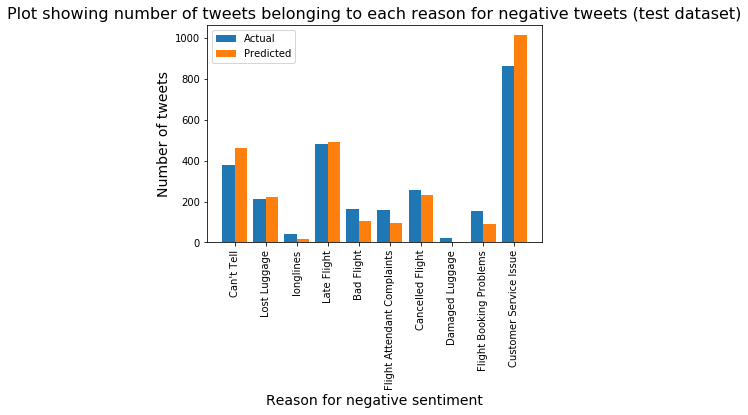

In [93]:
reasons = list(set(list(df_at_neg['negative_reason'])))
print (reasons)
X = np.arange(len(reasons))
Y1 = [len(df_at_neg_test[df_at_neg_test['negative_reason'] == reason]) for reason in reasons]
Y2 = [len(df_at_neg_test[df_at_neg_test['Reason_Prediction'] == reason]) for reason in reasons]

p1 = plt.bar(X, Y1, width = 0.4)
p2 = plt.bar(X+0.4, Y2, width = 0.4)
plt.xticks(X+0.2,reasons, rotation='vertical')
plt.ylabel("Number of tweets", fontsize = 14)
plt.xlabel("Reason for negative sentiment", fontsize = 14)
plt.title("Plot showing number of tweets belonging to each reason for negative tweets (test dataset)", fontsize = 16)
plt.legend((p1[0], p2[0]), ('Actual', 'Predicted'), loc='best')

In [94]:
df_at_eg = df_at_neg_test[df_at_neg_test['negative_reason'] == 'Damaged Luggage']

Following dataframe slice is shown as references have been made to this in the "Results and Discussion" section that appears further on.

In [95]:
df_at_eg[['text','negative_reason','Reason_Prediction']]

,text,negative_reason,Reason_Prediction
7624,great will media filmcrew photography cameragear,Damaged Luggage,Customer Service Issue
359,unfortunate xmas gift razor ripped front pocke...,Damaged Luggage,Can't Tell
7473,horrible service luggage destroyed flight woma...,Damaged Luggage,Lost Luggage
4772,2 fight 2 credit bag skytrax jetblue corpgreed...,Damaged Luggage,Lost Luggage
7797,understand oneworld member treat customers fai...,Damaged Luggage,Customer Service Issue
106,luggage severely dentedmissing wheel coming ba...,Damaged Luggage,Lost Luggage
7931,airline ruined bag refuse,Damaged Luggage,Lost Luggage
3131,- baggage motto cover small tear ripped seam s...,Damaged Luggage,Can't Tell
3075,deserves red carpet tx destroy luggage &only 7...,Damaged Luggage,Lost Luggage
4925,stroller travel credit help cover cost strolle...,Damaged Luggage,Flight Attendant Complaints


### Results and discussion
#### Model 1 (trained on generic tweets)
1. The model generated for classification of tweets into positive and negative based on sentiment, has an overall accuracy of ~ 71% (value changes slightly based on the train-test split) which means for a given tweet set, the model will accurately predict the correct sentiment class (+ve or -ve) of about 71% of the samples.
2. The precision for classification into negative sentiment tweets (0.74) is higher compared to the classification into positive sentiment (0.68) meaning the model can more accurately predict a negative tweet than a positive tweet.
3. However, the sensitivity (recall) is higher for the positive sentiment class (0.78) than the negative sentiment class (0.64).
4. When this model is used to predict the sentiment of the airline tweets, the accuracy of the prediction drops to ~ 55%, i.e. the model accurately predicts the correct sentiment class (+ve or -ve) of about 55% of the airline tweets.
5. An interesting observation is that the model predictions result in lesser false negatives than previous case (i.e. higher precision in negative sentiment class: 85%) but much greater false positives (i.e. lower precision in positive sentiment class: 26%). This means, that there are more chances of an actual negative tweet being ignored (because it was classified as a positive) by this particular model, which is not favourable for the airline companies with focus on improving customer service.
6. This fact is better expressed by the additional figure generated (as part of Bonus Work) showing the percentage of positive tweets, both predicted and actual, for each airlines. Therefore, for 2015, public opinion on twitter (in general), when used to identify the satisfaction/dissatisfaction of customers based on the sentiment of the tweet, results in a model that overestimates the number of positive sentiment tweets for each airline.
7. The sensitivity is still higher for the positive sentiment class (0.65) compared to the negative one (0.53).
8. Another interesting observation that can be made is that assuming the model is sufficiently accurate for a generic environment, all the airlines (ignoring the case of Frontier Airlines as there is only 1 data point for it) have positve tweets ranging from ~(40% to 60%), showing that, to the public eye the sentiment is more or less balanced, with Spirit Airlines, Delta Airlines and Alaska Airlines (Alaska includes Virgin America) leading the way.

#### Model 2 (trained on negative tweets in the airline dataset)
1. The model generated for the finding the reason associated with the negative tweet has an accuracy of ~ 61%, i.e. for 61% of the total tweets, the reason was predicted correctly.
2. The precision of prediction is highest for "Damaged luggage": 100%, followed by "Cancelled flight": 79% and "Late Flight": 70%. It is the lowest for "longlines": 27%.
3. The sensitivity/recall is highest for "Customer service issue": 75%, followed by "Late flight": 71% and "Cancelled flight": 70%
##### Reasons for the poor model (Model 2)
>1. Synonymous words e.g. bag and luggage have been differentiated by the model. With the result, even if the tweet has "...damaged bag..." it is not classified in "Damaged luggage". This may be because the word "bag" has a higher importance for "Lost luggage" class than "Damaged luggage" class. This is also evident from the confusion matrix which shows that the majority of falsely classified tweets in "Damaged luggage" class (total 27) have been classified as "Lost luggage" (12) compared to its true class (only 4).
>2. Moreover, the reasons themselves may not be independent of each other as someone who has lost their luggage would go to the customer service desk to report it in addition to those who found it damaged. For such cases figuring out the exact reason of dissatisfaction may require higher level n-grams to account for the precedence relationship.

#### Ways to improve the models:
1. Increasing the feature size can help improve the accuracy of the model. Currently the feature size was kept at 1000 due to memory constraints.
2. The usage of n-grams of higher n values (i.e. trigrams, etc.) can also be tried. Though this may result in some loss of objectivity in the analysis for higher n values, but would benefit in the case of model 2.
3. Instead of simply using the frequency itself, the frequency value can be multiplied to the sentiment value of each word or n-gram (obtained from libraries like TextBlob) to design better features.
4. By default the Logistic model in sklearn uses 'l2' penalty corresponding to ridge regression. Choosing 'l1' penalty may result in removal of unimportant features that may improve the performance of the model.

### BONUS Figure
##### Heatmap showing the confusion matrix in multiclass logistic regression for negative sentiment

Text(32.99999999999999, 0.5, 'True class')

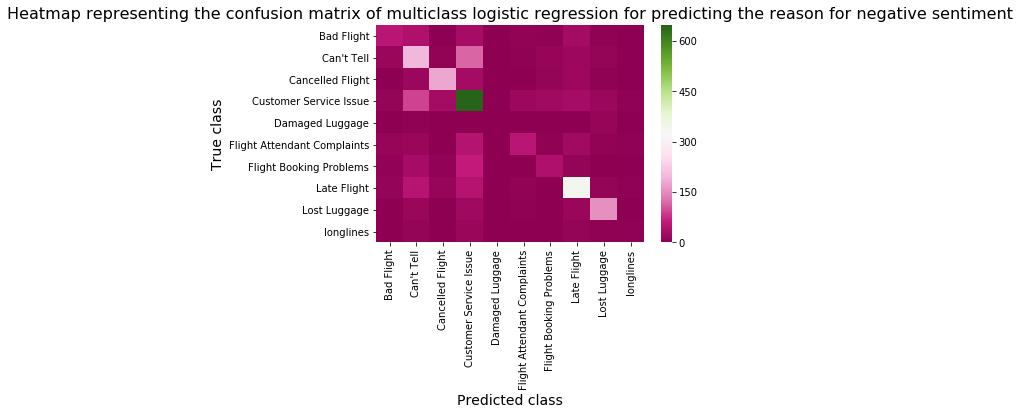

In [96]:
hm = seaborn.heatmap(confusion_matrix(new_Y_at_test,predictions_at_new),xticklabels=sorted(reasons), yticklabels=sorted(reasons),cmap='PiYG')
hm.set_title("Heatmap representing the confusion matrix of multiclass logistic regression for predicting the reason for negative sentiment", fontsize=16)
hm.set_xlabel("Predicted class",fontsize=14)
hm.set_ylabel("True class",fontsize=14)